main miniGAP notebook

In [2]:
import sys
sys.path.append('../code')
from Molecular_Dynamics import generate_md_traj, make_diatomic
from Generate_Descriptors import get_dscribe_descriptors

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import gpflow
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tfp.math.psd_kernels
from gpflow.kernels import SquaredExponential, Polynomial
from itertools import islice
from  tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
from ase.io import read
import pandas as pd

In [19]:
print("GPUs recognized by tensorflow:", tf.config.list_physical_devices('GPU'))

GPUs recognized by tensorflow: []


In [3]:
# some basic helper functions
import time

def PrintNoScientificNotation(*x):
    np.set_printoptions(suppress=True) # Do not print in scientific notation
    print(*x)
    np.set_printoptions(suppress=False)
       
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

In [4]:
# These plotting settings make graphs easier to read
# This is a very clunky way to do this so I want to move this soon, but haven't had much of a chance

SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIG_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title

---

# Current Training (As of 10/27)
### Broken into a bunch of steps with comments

---

## Prep work

In [5]:
FullStructureList = read("../data/distorted_propanol.extxyz.gz", ":")#, ":{}".format(my_n))
print("Loaded {} structures into FullStructureList".format(len(FullStructureList)))

Loaded 2000 structures into FullStructureList


Define all settings now

In [37]:
# I only use these settings if I am training on diatomic structures
# ------------------------------------------------------------------------
use_diatomics = True
if use_diatomics:
    my_element = "O"
    my_temp=10
    my_calc = "EMT"
    my_md_seed = 1

# Number of structures    
# ------------------------------------------------------------------------
my_n = 200

# Energy parameters
# ------------------------------------------------------------------------
use_self_energies = False

# SOAP parameters
# ------------------------------------------------------------------------
my_rcut = 5
my_nmax = 8
my_lmax = 8
my_smear = 0.3
attach_SOAP_center = True
is_periodic = False

# Training parameters
# ------------------------------------------------------------------------
sparse_gpflow = False
n_sparse = 80
use_forces = False
scale_soaps = False
# controls initial train_test_split breaking apart training and test data
split_seed = 2
# controls in-training train_test_split breaking apart training_j and validation_j data
valid_split_seed = 2
# controls multiple tf stochastic processes including:
# 1) Adams optimizer AND 
# 2) batching through tf.data.Dataset.from_tensor_slices in training
tf_seed = 2
# controls batching through tf.data.Dataset.from_tensor_slices in training
shuffle_seed = 2
kernel_type = "polynomial"#"exponentiated_quadratic"#"polynomial"
training_frac = 0.9
valid_fract = 0.9
batch_size_max = 5000#00
learn_rate = 2e-2 # 1e5#.01#10#0.5
n_epochs_max = 0#300
print_frequency = 1
prediction_calculation = "direct" #"direct" OR "predict_f" OR "cholesky" OR "alpha"

# Does nothing
no_forces_string = "Not Using Forces"


Pick which structures to train

In [38]:
# Diatomic molecule with evenly spaced bond lengths
#StructureList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.6,1.8, my_n)]

# Diatomic molecule in MD trajectory
#StructureList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed, time_step=.6)

# 2000 distorted propanols (librascal structures)
#   Forces included
#StructureList = read("../data/distorted_propanol.extxyz.gz", ":{}".format(my_n))
StructureList = FullStructureList[::len(FullStructureList)//my_n][:my_n]
# 10000 graphenes from Alvaro
#   Forces included
# StructureList = read("../data/ManyGraphenes.gz", ":{}".format(my_n))

# 6095 isomers of C7O2H10 (subset of QM9)
#   No forces
# StructureList = read("../data/C7O2H10.extxyz.gz", ":{}".format(my_n))

print("Using {} structures.".format(len(StructureList)))

Using 200 structures.


Parse data from dataset

In [39]:
def self_energy(element, use_librascal_values=False):
    if use_librascal_values:
        self_contributions = {
            "H": -6.492647589968434,
            "C": -38.054950840332474,
            "O": -83.97955098636527,
        }
        return self_contributions[element]
    else:
        return np.float64(0)

In [40]:
def GatherStructureInfo(struct_list = StructureList, gather_forces = use_forces, use_self_energies=use_self_energies ):

    pos_list =  np.array([atoms.positions for atoms in struct_list])
    
    en_list = np.array([[struct.get_potential_energy()/len(struct) - self_energy(atom.symbol, use_self_energies) for atom in struct] for struct in struct_list], dtype=np.float64)

    if gather_forces:
        frc_list = np.array([atom.get_forces() for atom in struct_list], dtype=np.float64)
    else:
        frc_list = [no_forces_string] * len(en_list)
        
    return en_list, frc_list, pos_list

EnergyList, ForceList, PosList = GatherStructureInfo(StructureList,gather_forces = use_forces, use_self_energies=use_self_energies )

Generate SOAP descriptors

In [41]:
def GenerateDescriptorsAndDerivatives(struct_list = StructureList,
                                     attach = attach_SOAP_center,
                                     is_periodic = is_periodic,
                                     return_derivatives = use_forces,
                                     nmax = my_nmax,
                                     lmax = my_lmax,
                                     rcut = my_rcut,
                                     smear = my_smear,
                                     get_local_descriptors = True):
    
    relevant_species = np.unique(struct_list[0].get_chemical_symbols())
    
    dscribe_output = get_dscribe_descriptors(
                                            struct_list, 
                                            species=relevant_species, 
                                            attach=attach, 
                                            is_periodic = is_periodic,
                                            is_global= not get_local_descriptors,
                                            return_derivatives= return_derivatives, 
                                            nmax=nmax, 
                                            lmax=lmax,
                                            rcut=rcut,
                                            smear=smear
    )

    if return_derivatives:
        dsp_dx_list, sp_list = dscribe_output
        dsp_dx_list = np.moveaxis(dsp_dx_list.diagonal(axis1=1, axis2=2), -1, 1)
        #SoapList = SoapList.reshape(-1, 1, SoapList.shape[-1])
        #SoapDerivativeList = SoapDerivativeList.reshape(-1, 1,  *SoapDerivativeList.shape[2:])
    else:
        sp_list = dscribe_output#.reshape(-1, 1, SoapList.shape[-1])
        dsp_dx_list = [no_forces_string] * len(sp_list)#sum(len(struct) for struct in struct_list)
    
    return dsp_dx_list, sp_list
        
[SoapDerivativeList, SoapList], TimeSoap = TickTock(GenerateDescriptorsAndDerivatives, StructureList, attach_SOAP_center, is_periodic, use_forces, my_nmax, my_lmax, my_rcut, my_smear)


In [42]:
print(TimeSoap)

0.19413375854492188


---

## Now the training starts

Preparing the energies, forces, soap descriptors and derivatives into a format usable for tensorflow training

---

1. Split all data into training and test sets.  
Test sets will not be viewed until training is done  
2. Scale soaps and energies separately to have zero mean and unit variance.  
Divide the derivatives by the same scale factor but don't subtract the mean
3. Convert data to tensorflow tensors where necessary  

In [83]:
def PrepareDataForTraining(sp_list = SoapList,
                           dsp_dx_list = SoapDerivativeList,
                           en_list = EnergyList,
                           frc_list = ForceList,
                           pos_list = PosList,
                           split_seed = split_seed,
                           prepare_forces = use_forces,
                           train_fract = training_frac,
                           scale_soaps = scale_soaps
                          ):
    # This comment itself needs to be split up now haha
    
    # Split all data into training and test sets.
    # Test sets will not be viewed until training is done
    # Intra-structural information is not reshaped into local atomic information until after splitting
    # This means structures will be fully in the training or test sets, not split between both
    # It also means it will be possible to predict global energies in the test set
    
    train_indices, test_indices  = train_test_split(np.arange(len(sp_list)), random_state = split_seed, test_size = 1 - train_fract )
    
    train_ens, test_ens = en_list[train_indices], en_list[test_indices] #, test_ens, train_frcs, test_frcs
    train_ens, test_ens = train_ens.reshape(-1, 1), test_ens.reshape(-1, 1)
    
    # Scale energies to have zero mean and unit variance.
    # Divide forces by the same scale factor but don't subtract the mean

    ens_scaler = StandardScaler().fit(train_ens)
    train_ens, test_ens = ens_scaler.transform(train_ens), ens_scaler.transform(test_ens)
    # The following line is for the tensorflow code. If it is commented out, it is for the gpflow code
    #train_ens, test_ens = train_ens.flatten(), test_ens.flatten()
    ens_var = train_ens.var()
    
    if prepare_forces:
        train_frcs, test_frcs = frc_list[train_indices], frc_list[test_indices]
        train_frcs, test_frcs = train_frcs.reshape(-1, 3), test_frcs.reshape(-1, 3)
        train_frcs, test_frcs = train_frcs / ens_scaler.scale_, test_frcs / ens_scaler.scale_
        frcs_var = train_frcs.var()
            
    
#     split_data = train_test_split(sp_list, dsp_dx_list, en_list, frc_list, pos_list, np.arange(len(sp_list)), random_state = split_seed, test_size = 1 - train_fract )
#     print([np.array(x).shape for x in split_data])
#     split_data = [np.array]
#     train_sps, test_sps, train_dsp_dx, test_dsp_dx, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data
    
    train_sps, test_sps = sp_list[train_indices], sp_list[test_indices]
    train_sps, test_sps = train_sps.reshape(-1, sp_list.shape[-1]), test_sps.reshape(-1, sp_list.shape[-1])  
    
    # Scale soaps to have zero mean and unit variance.
    # Divide derivatives by the same scale factor but don't subtract the mean
    
    soap_scaler = StandardScaler().fit(train_sps)
    if scale_soaps:
        train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
    
    if prepare_forces:
        train_dsp_dx, test_dsp_dx = dsp_dx_list[train_indices], dsp_dx_list[test_indices]
        train_dsp_dx, test_dsp_dx = train_dsp_dx.reshape(-1, 3, dsp_dx_list.shape[-1]), test_dsp_dx.reshape(-1, 3, dsp_dx_list.shape[-1])
        if scale_soaps:
            train_dsp_dx, test_dsp_dx = train_dsp_dx/soap_scaler.scale_, test_dsp_dx/soap_scaler.scale_

    # Convert data to tensorflow tensors where necessary
    
    # Maybe it makes sense to wait to do this since I have to convert them back to numpy to split them into validation/training sets anyway
    # (The only one I didn't have to convert is test_sps, but I can just do this later if I'm moving the rest to later)
#     train_sps = tf.constant(train_sps, dtype=np.float64)
#     train_ens = tf.constant(train_ens, dtype=np.float64)
#     test_sps = tf.constant(test_sps, dtype=np.float64)

#     if prepare_forces:
#         train_frcs = tf.constant(train_frcs, dtype=np.float64)

    if not prepare_forces:
        return train_sps, test_sps, train_ens, test_ens, train_indices, test_indices, soap_scaler, ens_scaler, ens_var
    else:
        return train_sps, test_sps, train_ens, test_ens, train_indices, test_indices, soap_scaler, ens_scaler, ens_var, train_dsp_dx, test_dsp_dx, train_frcs, test_frcs, frcs_var

out_data, TimePrepare = TickTock(PrepareDataForTraining, SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, split_seed, use_forces, training_frac)

print(TimePrepare)

if not use_forces:
    train_sps, test_sps, train_ens, test_ens, train_indices, test_indices, soap_scaler, ens_scaler, ens_var = out_data
else:
    train_sps, test_sps, train_ens, test_ens, train_indices, test_indices, soap_scaler, ens_scaler, ens_var, train_dsp_dx, test_dsp_dx, train_frcs, test_frcs, frcs_var = out_data 


0.05041003227233887


In [84]:
if sparse_gpflow:
    from skcosmo.sample_selection import CUR
    from sklearn.decomposition import PCA
    
    PCA_model = PCA(2).fit(train_sps)
    train_sps_2D = PCA_model.transform(train_sps)
    
        
    selector2 = CUR(
                        n_to_select=n_sparse,
                        progress_bar=True,
                        score_threshold=1E-12,
                        full=False,

                        # int, number of eigenvectors to use in computing pi
                        k = 1,

                        # boolean, whether to orthogonalize after each selection, defaults to true
                        iterative = True,

                        # float, threshold below which scores will be considered 0, defaults to 1E-12
                        tolerance=1E-12,
                        )
    
    selector2.fit(train_sps_2D)
    sparse_train_sps_2D_2 = selector2.transform(train_sps_2D)
    
    
    selector1 = CUR(
                        n_to_select=n_sparse,
                        progress_bar=True,
                        score_threshold=1E-12,
                        full=False,

                        # int, number of eigenvectors to use in computing pi
                        k = 1,

                        # boolean, whether to orthogonalize after each selection, defaults to true
                        iterative = True,

                        # float, threshold below which scores will be considered 0, defaults to 1E-12
                        tolerance=1E-12,
                        )
    selector1.fit(train_sps)
    sparse_train_sps = selector1.transform(train_sps)
    sparse_train_sps_2D = PCA_model.transform(sparse_train_sps)


    
    plt.plot(train_sps_2D.transpose()[0],train_sps_2D.transpose()[1], "o" , c='r', ms=1)
    plt.plot(sparse_train_sps_2D.transpose()[0],sparse_train_sps_2D.transpose()[1], "o" ,c='b')
    plt.plot(sparse_train_sps_2D_2.transpose()[0],sparse_train_sps_2D_2.transpose()[1], "o" , c='g')
    
    print(
        sparse_train_sps.shape,
        train_sps.shape,
        sparse_train_sps_2D.shape,
        sparse_train_sps_2D_2.shape
        )

Reshape energies, soaps, etc so that local data can be separated

Scale soaps and energies separately to have zero mean and unit variance.

Divide the derivatives by the same scale factor but don't subtract the mean

Convert data to tensorflow tensors where necessary

Define a few things used in training loop

* loss/error function
* optimizer

In [85]:
from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

In [86]:
# Note: I still need to add the Tikhonov regularization term for loss to make the mse equivalent to negative log likelihood

@tf.function(autograph=False, experimental_compile=False)
def mse(y_predict, y_true):
    return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

@tf.function(autograph=False, experimental_compile=False)
def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
    mse1 = mse(y1_predict, y1_true)
    mse2 = mse(y2_predict, y2_true)*3

    return mse1 * weight1 + mse2 * weight2



In [87]:
#@tf.function(autograph=False, experimental_compile=False)
def train_step_without_forces_full(model, valid_soap, valid_energy): #, optimizer):
    with tf.GradientTape() as tape:
        predict_energy = model.predict_f(valid_soap)[0]
        tf.print("predict energies = ", predict_energy[:3])
        my_mse = mse(predict_energy, valid_energy)
    gradients = tape.gradient(my_mse, model.trainable_variables)
    tf.print("gradients = ", gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print("TRACING train_step_without_forces_full")
    return my_mse

In [88]:
@tf.function(autograph=False, experimental_compile=False)
def predict_energies_from_weights(c, soaps_old, soaps_new):
    k = tf.tensordot(soaps_old, tf.transpose(soaps_new), axes=1)
    return tf.linalg.matmul(c, k, transpose_a=True)

### Possible improvements to my GPflow training
---
1. Use Adam optimizer
2. Custom loss function vs optimizer.minimize
3. Don't use constrain_positive
4. Set certain variable untrainable

Perform training loop

In [146]:
# Initialize kernels and model hyperparameters
verbose = True
tf.random.set_seed(tf_seed)

TimeBeforePreEpoch = time.time()


train_step_without_forces_full_tf = tf.function(train_step_without_forces_full)

#optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
optimizer = tf.keras.optimizers.SGD(learning_rate=learn_rate)


constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
noise_init = 1e-4
obs_noise = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise")

if kernel_type == "exponentiated_quadratic":
    amp_init = 2
    # The following line tries to control for the size and natural spread of the data
    len_init = 0.1*train_sps.shape[-1]/np.mean(soap_scaler.scale_ )
    amplitude = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude")
    len_scale = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale")
#     kernel = tfk.ExponentiatedQuadratic(amplitude=amplitude, length_scale=len_scale, name="exponentiated_quadratic_kernel", feature_ndims=1)
    kernel = SquaredExponential(variance=amplitude, lengthscales=len_scale, name="exponentiated_quadratic_kernel_gpf")
#     trainable_variables = [var.variables[0] for var in [amplitude, len_scale, obs_noise]]
elif kernel_type == "polynomial":
    slope_init = 1
#    slope = tfp.util.TransformedVariable(initial_value=slope_init, bijector=constrain_positive, dtype=np.float64, name="slope")
    offset_init =  1e-24#1e-10
    offset = tf.Variable(offset_init, dtype=np.float64, name="offset")
#    offset = tfp.util.TransformedVariable(initial_value=offset_init, bijector=constrain_positive, dtype=np.float64, name="offset")
    degree_init = 1
    degree = tf.constant(degree_init, dtype=np.float64, name="degree")
    print("Raising linear kernel to the power of {} creating a polynomial kernel".format(degree_init))
#    degree = tfp.util.TransformedVariable(initial_value=degree_init, bijector=constrain_positive, dtype=np.float64, name="degree")
    kernel = Polynomial(variance=slope_init, offset=offset, degree=degree_init)
#     kernel = tfk.Polynomial(slope_variance=slope, name="polynomial_kernel", feature_ndims=1)

#     trainable_variables = [var.variables[0] for var in [slope, obs_noise]]
else:
    print("Warning: Do not recognize kernel_type={}".format(kernel_type))

    


# Split training data into training and validation sets
# Now validation set acts as temporary est set
# train_test_split and tensorflow tensors don't get along so I temporarily convert them back to numpy arrays

train_indices_j, valid_indices_j  = train_test_split(np.arange(len(train_sps)), random_state = valid_split_seed, test_size=(1-valid_fract))

train_sps_j, valid_sps_j = train_sps[train_indices_j], train_sps[valid_indices_j]
train_ens_j, valid_ens_j = train_ens[train_indices_j], train_ens[valid_indices_j]

if use_forces: 
    train_dsp_dx_j, valid_dsp_dx_j = train_dsp_dx[train_indices_j], train_dsp_dx[valid_indices_j]
    train_frcs_j, valid_frcs_j = train_frcs[train_indices_j], train_frcs[valid_indices_j]

# Convert to tensorflow constant tensors
train_sps_j = tf.constant(train_sps_j, dtype=np.float64)
train_ens_j = tf.constant(train_ens_j, dtype=np.float64)
valid_sps_j = tf.constant(valid_sps_j, dtype=np.float64)
valid_ens_j = tf.constant(valid_ens_j, dtype=np.float64)
if sparse_gpflow:
    sparse_train_sps = tf.Variable(sparse_train_sps, shape=sparse_train_sps.shape, dtype=np.float64, trainable=False)

if use_forces:
    train_dsp_dx_j = tf.constant(train_dsp_dx_j, dtype=np.float64)
    train_frcs_j = tf.constant(train_frcs_j, dtype=np.float64)    
    valid_dsp_dx_j = tf.constant(valid_dsp_dx_j, dtype=np.float64)
    valid_frcs_j = tf.constant(valid_frcs_j, dtype=np.float64)        

test_sps = tf.constant(test_sps, dtype=np.float64)


# Batch data if  training set is larger than batch_size_max
if len(train_sps_j) < batch_size_max:
    iterations_per_epoch = 1
    batch_size = len(train_sps_j)
    if verbose:
        print("Training using {} atoms without batching.".format(len(train_sps_j)))
else:
    iterations_per_epoch = int(np.ceil(len(train_sps_j)/batch_size_max))
    batch_size = int(np.ceil(len(train_sps_j)/iterations_per_epoch))
    if verbose:
        print("Training using {} atoms total using {} batches with {} atoms per batch.".format( len(train_sps_j), iterations_per_epoch, batch_size ))

# training(out_data)
        
TimeBeforeEpoch0 = time.time()


mse_history = []    
hyperparam_history = []



batches_j = (
    tf.data.Dataset.from_tensor_slices((train_sps_j, train_ens_j)) 
    .shuffle(buffer_size=len(train_sps_j), seed=shuffle_seed) 
    .repeat(count=None)
    .batch(batch_size)
)    

# new code to make tf.function training work
# --------------------------------------------
train_sps_j_i = tf.Variable(train_sps[:batch_size], shape=(batch_size, train_sps.shape[-1]), dtype=np.float64, trainable=False )
train_ens_j_i = tf.Variable(train_ens[:batch_size], shape=(batch_size, 1), dtype=np.float64, trainable=False ) 
if sparse_gpflow:
    if n_sparse >= batch_size:
        print("Warning: Batch size is not greater than sparse soap size.\nThis may cause errors in the predict_f function which assumes the inducing points to be fewer than the data points.")
    gpr_model = gpflow.models.SGPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel, noise_variance=obs_noise, inducing_variable=sparse_train_sps)
else:
    gpr_model = gpflow.models.GPR( data=(train_sps_j_i, train_ens_j_i), kernel=kernel, noise_variance=obs_noise)
# --------------------------------------------


hyperparam_history.append([(0, var.numpy()) for var in gpr_model.trainable_parameters])  
for j in range(n_epochs_max):
    if not j % print_frequency:
        print("Epoch {}".format(j))
        #print(" ".join(["{} = {:.2e} ".format(var.name, np.exp(var.numpy())) for var in trainable_variables]))



    mse_ens_j = 0
    for i, (train_sps_j_i, train_ens_j_i) in enumerate(islice(batches_j, iterations_per_epoch)):
        if not use_forces: #and not sparse_gpflow :
            gpr_model.data[0].assign(train_sps_j_i)
            gpr_model.data[1].assign(train_ens_j_i)        
            mse_ens_j_i = train_step_without_forces_full_tf(gpr_model, valid_sps_j, valid_ens_j)
#             mse_ens_j_i = train_step_without_forces_full_tf(gpr_model, valid_sps_j, valid_ens_j)
            print(mse_ens_j_i.numpy(), valid_ens_j[:3].numpy().flatten(), train_ens_j_i[:3].numpy().flatten()  )
        else:
            print("Using normal approach")
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
                    tape_sps.watch(valid_sps_j)
    #                 gprm_j_i = tfd.GaussianProcessRegressionModel(
    #                     kernel = kernel,
    #                     index_points = valid_sps_j,
    #                     observation_index_points = train_sps_j_i,
    #                     observations = train_ens_j_i, #tf.constant(train_ens_j_i.numpy().flatten(), dtype=np.float64),#train_ens_j_i,
    #                     observation_noise_variance = obs_noise)
    #                 predict_ens_j_i = gprm_j_i.mean()
                    if sparse_gpflow:
                        gpr_model = gpflow.models.SGPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel, inducing_variable=sparse_train_sps)
#                         gpflow.set_trainable(gpr_model.inducing_variable, False)
                        if i < 3:
                            print_summary(gpr_model)            
                    else:
                        gpr_model.data[0].assign(train_sps_j_i)
                        gpr_model.data[1].assign(train_ens_j_i)
                        #gpr_model = gpflow.models.GPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel)
                    #gpr_model.likelihood.variance.assign(obs_noise)                
                    predict_ens_j_i = gpr_model.predict_f(valid_sps_j)[0]



    #                 gpr_model = gpflow.models.GPR(data=(sps_j_i, train_ens_j_i), kernel=kernel_gpf)
    #                 gpr_model.likelihood.variance.assign(obs_noise_gpf)
    #                 predict_ens_j_i_gpf = gpr_model.predict_f(valid_sps_j)

                if use_forces:
                    predict_d_ens_j_i = tape_sps.gradient(predict_ens_j_i, valid_sps_j)
                    # In the following line I needed to include '* n_atoms' after breaking energies into local energies
                    # The reason is that I am effectively breaking the connection between E and F when doing that
                    # F = -dE/dx =/= -dE_local/dx where E_local = E/n_atoms - E_free
                    # When I split energies into local energies I initially calculated -dE_local/dx which is -dE/dx / n_atoms
                    # This fix is prone to breaking the code and is not robust to systems with different structure size
                    # Need to improve this with a better fix
                    n_atoms = len(StructureList[0])
                    predict_frcs_j_i = -1*np.einsum('ijk,ik->ij', valid_dsp_dx_j, predict_d_ens_j_i) * n_atoms
                    mse_j_i = mse_2factor(predict_ens_j_i, valid_ens_j, 1/ens_var,
                                            predict_frcs_j_i, valid_frcs_j, 1/frcs_var)
                    mse_ens_j_i = mse(predict_ens_j_i, valid_ens_j)
                else:
                    mse_j_i = mse(predict_ens_j_i, valid_ens_j)
                    mse_ens_j_i = mse_j_i


    #         grads = tape.gradient(mse_j_i, trainable_variables)
    #         optimizer.apply_gradients(zip(grads, trainable_variables))
            grads = tape.gradient(mse_j_i, gpr_model.trainable_variables)
            # print(gpr_model.trainable_variables[0])#grads[0])
            optimizer.apply_gradients(zip(grads, gpr_model.trainable_variables))
            if i < 3:
                print_summary(gpr_model)
                
            if not gpr_model.data[0][0,0].numpy() == train_sps_j_i[0,0].numpy() :
                print("ERRORERRORERRORERRORERRORERRORERROR")

        print("Adding mse_ens_j_i to mse_ens_j: {} + {} = {} ".format(mse_ens_j_i.numpy(), mse_ens_j , mse_ens_j_i.numpy() + mse_ens_j  ))
        mse_ens_j += mse_ens_j_i

    mse_ens_j /= iterations_per_epoch
    #print("Epoch {},  mse = {}".format(j, mse_ens_j))
    mse_history.append((j+1, mse_ens_j))
    hyperparam_history.append([(j+1, var.numpy()) for var in gpr_model.trainable_parameters])    

print_summary(gpr_model)

TimeBeforeWeights = time.time()
print("Calculating weights")

if sparse_gpflow:
    gpr_model = gpflow.models.SGPR(data=(train_sps, train_ens), kernel=kernel, noise_variance = gpr_model.likelihood.variance, inducing_variable  = sparse_train_sps)
else:
    gpr_model = gpflow.models.GPR( data=(train_sps, train_ens), kernel=kernel, noise_variance = gpr_model.likelihood.variance)      

if sparse_gpflow:
    if prediction_calculation in ("direct", "cholesky"):
        print("Alert: {} prediction approach not implemented for sparse model. Using alpha approach instead.".format(prediction_calculation))
        trained_weights = gpr_model.posterior().alpha
    elif prediction_calculation == "alpha":
        trained_weights = gpr_model.posterior().alpha
else:
    if prediction_calculation in ("direct", "cholesky"):
        KNN = gpr_model.kernel(train_sps)
        KNN_diag = tf.linalg.diag_part(KNN)
        variance_diag = tf.fill(tf.shape(KNN_diag), gpr_model.likelihood.variance)
        KNN_plus_variance = tf.linalg.set_diag(KNN, KNN_diag + variance_diag)
        if prediction_calculation == "direct":
            KNN_inv =  tf.linalg.inv(KNN_plus_variance)
            trained_weights = tf.matmul(KNN_inv, train_ens)
        else:
            LNN = tf.linalg.cholesky(KNN_plus_variance)
            LNN_inv = tf.linalg.inv(LNN)
            KNN_inv_from_L = tf.matmul(LNN_inv, LNN_inv,transpose_a=True)
            trained_weights = tf.matmul(KNN_inv_from_L, train_ens)
    elif prediction_calculation == "alpha":
        print("ERROR: alpha not implemented for gpflow GPR. Skipping prediction")

    
TimeAfterTraining = time.time()


with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
    tape_sps.watch(test_sps)  
    print("Predicting final energies")
    if prediction_calculation == "predict_f":
        predict_ens = gpr_model.predict_f(test_sps)[0]
    else:
        if sparse_gpflow:
            predict_ens = tf.reshape( predict_energies_from_weights(trained_weights, sparse_train_sps, test_sps), [-1,1])
        else:
            predict_ens = tf.reshape( predict_energies_from_weights(trained_weights,        train_sps, test_sps), [-1,1])

test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
predict_ens_rescaled = ens_scaler.inverse_transform(predict_ens)

if use_forces:
    print("Predicting final forces")    
    predict_d_ens = tape_sps.gradient(predict_ens, test_sps)
    n_atoms = len(StructureList[0])
    predict_frcs = -1*np.einsum('ijk,ik->ij', test_dsp_dx, predict_d_ens) * n_atoms

    test_frcs_rescaled = test_frcs * ens_scaler.scale_
    predict_frcs_rescaled = predict_frcs * ens_scaler.scale_

TimeAfterPrediction = time.time()




Raising linear kernel to the power of 1 creating a polynomial kernel
Training using 1620 atoms without batching.


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.offset,Parameter,Softplus,,True,(),float64,1.000000000000002e-24
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00010000000000000011
GPR.data[0],ResourceVariable,,,False,"(1620, 2700)",float64,"[[1.71329899e-03, 3.23732481e-03, -6.96002674e-03..."
GPR.data[1],ResourceVariable,,,False,"(1620, 1)",float64,[[-0.64663941...


Calculating weights
Predicting final energies


In [153]:
%timeit KNN = gpr_model.kernel(train_sps)

%timeit get_KNN(train_sps)

255 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
222 ms ± 5.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [163]:
@tf.function(autograph=False, experimental_compile=False)
def direct_weight_calculation(KNN, variance, y):
    KNN_diag = tf.linalg.diag_part(KNN)
    variance_diag = tf.fill(tf.shape(KNN_diag), variance)
    KNN_plus_variance = tf.linalg.set_diag(KNN, KNN_diag + variance_diag)
    KNN_inv =  tf.linalg.inv(KNN_plus_variance)
    return tf.matmul(KNN_inv, y)

@tf.function(autograph=False, experimental_compile=False)
def cholesky_weight_calculation(KNN, variance, y):
    KNN_diag = tf.linalg.diag_part(KNN)
    variance_diag = tf.fill(tf.shape(KNN_diag), variance)
    KNN_plus_variance = tf.linalg.set_diag(KNN, KNN_diag + variance_diag)
    LNN = tf.linalg.cholesky(KNN_plus_variance)
    LNN_inv = tf.linalg.inv(LNN)
    KNN_inv_from_L = tf.matmul(LNN_inv, LNN_inv,transpose_a=True)
    return tf.matmul(KNN_inv_from_L, y)

train_ens_tf = tf.constant(train_ens, dtype=np.float64)

%timeit direct_weight_calculation(KNN, gpr_model.likelihood.variance, train_ens_tf)

%timeit cholesky_weight_calculation(KNN, gpr_model.likelihood.variance, train_ens_tf)

%timeit get_coefficients(KNN, gpr_model.likelihood.variance, train_ens_tf)

1.23 s ± 9.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.6 s ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.25 s ± 7.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
TrainingCellNonEpochsTraining = TimeBeforeEpoch0 - TimeBeforePreEpoch + TimeAfterTraining - TimeBeforeWeights 
if n_epochs_max:
    TimePerEpoch = (TimeBeforeWeights - TimeBeforeEpoch0)/n_epochs_max
else:
    TimePerEpoch = "N/A"
PredictionTime = TimeAfterPrediction - TimeAfterTraining

print("{:50s}: {:.3f}".format("Training time outside of epochs in training cell", TrainingCellNonEpochsTraining))
if n_epochs_max:
    print("{:50s}: {:.3f}".format( "Training time per epoch", TimePerEpoch))
print("{:50s}: {:.3f}".format("Prediction time", PredictionTime) )



Training time outside of epochs in training cell  : 1.490
Prediction time                                   : 0.055


In [91]:
if 'mse_history_by_n' not in locals():
    mse_history_by_n = {}
if 'hyperparam_history_by_n' not in locals():
    hyperparam_history_by_n = {}
    
hyperparam_history_by_n[my_n] = hyperparam_history
mse_history_by_n[my_n] = mse_history

print("Stored the hyperparameters and mse values for plotting under n={}".format(my_n) )

Stored the hyperparameters and mse values for plotting under n=200


Plot results

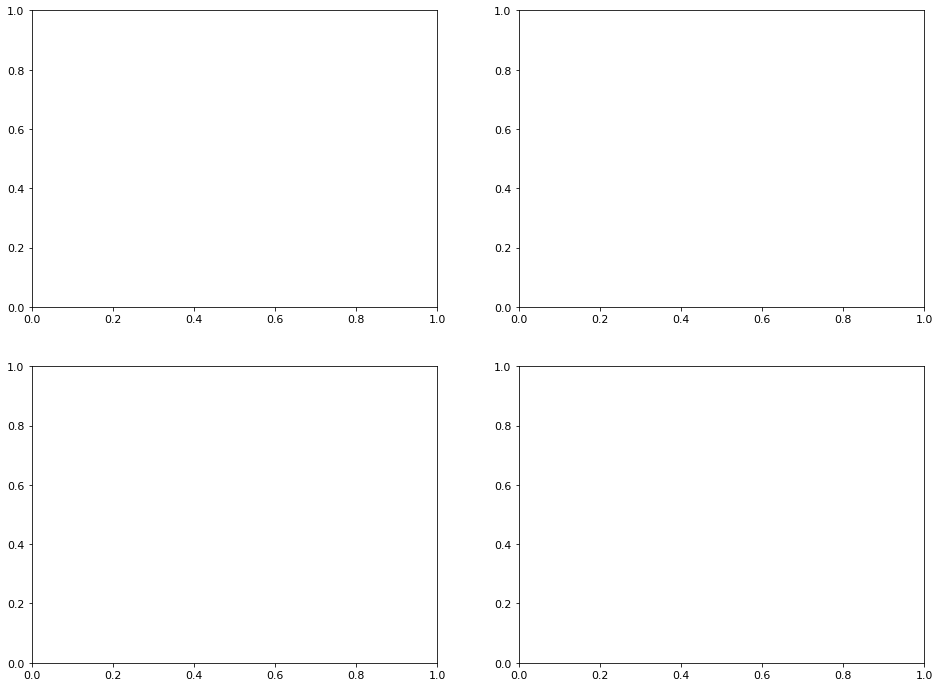

In [92]:

palette = plt.get_cmap('gist_ncar')#'nipy_spectral')#"viridis")
palette_size = palette.N#len(palette.colors)
palette_itr = 0

fig, [[ax00, ax01], [ax10, ax11]] = plt.subplots(nrows=2, ncols = 2, figsize=(16,12))

hyperparam_names = ["kernel offset", "kernel amplitude", "observation noise variance"]

for n in np.sort(list(mse_history_by_n.keys())):
    mse_history = mse_history_by_n[n]
    hyperparam_history = hyperparam_history_by_n[n]
    if not len(mse_history):
        continue
    color = palette(palette_itr)
    palette_itr = (palette_itr + 30) % palette_size
    

    
    # hyperparameters on axes 00, 01, 10
    hyperparams = np.swapaxes(hyperparam_history, 0, 1)

    ax00.plot(*zip(*hyperparams[0]), color=color, label="{}".format(n), lw=3)
    ax00.plot(*hyperparams[0][-1], "o", color=color)
    label00 = hyperparam_names[0]
    ax00.set_ylabel("{}".format(label00))
#     #ax00.set_yscale('log')
#     annotation00 = ax00.annotate('{:.1f}'.format(amplitudes[-1][1]) , xy=amplitudes[-1], xycoords='data', xytext=(-30,100),
#                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
    ax00.legend()

    ax01.plot(*zip(*hyperparams[1]), color=color, label="{}".format(n), lw=3)
    ax01.plot(*hyperparams[1][-1], "o", color=color)
    label01 = hyperparam_names[1]
    ax01.set_ylabel("{}".format(label01))
#     #ax01.set_yscale('log')
#     annotation01 = ax01.annotate('{:.1f}'.format(lengths[-1][1]) , xy=lengths[-1], xycoords='data', xytext=(100,-30), 
#                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
    ax01.legend()

    ax10.plot(*zip(*hyperparams[-1]), color=color, label="{}".format(n), lw=3)
    ax10.plot(*hyperparams[-1][-1], "o", color=color)
    label10 = hyperparam_names[-1]
    ax10.set_ylabel("{}".format(label10))
    #ax10.set_yscale('log')
#     annotation01 = ax10.annotate('{:.1e}'.format(noises[-1][1]) , xy=noises[-1], xycoords='data', xytext=(-30,100),
#                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
#     ax10.legend()

    #loss on axis 11
    ax11.plot(*zip(*mse_history), color = color, label="{}".format(n), lw=3)
    ax11.plot(*mse_history[-1], "o", color=color)
    #ax11.set_yscale('log')
    bottom, top = ax11.get_ylim()
    bottom2, top2 = ax11.get_ylim()
    ax11.set_ylabel("mse")
    ax11.legend()

    #fig.suptitle("{}".format(my_n))

In [139]:
def plot_errors(global_ens, predicted_global_ens, model_description = "model", use_local=False, local_ens=[], predicted_local_ens=[], color="mediumseagreen"):
    n_atoms = 10
    
    global_ens, predicted_global_ens, local_ens, predicted_local_ens = np.array(global_ens), np.array(predicted_global_ens), np.array(local_ens), np.array(predicted_local_ens)
    
    if use_local:
        fig, axs = plt.subplots(figsize=(20,4.5), ncols=3)
    else:
        fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

    axs[0].set_title("Predicted Global Energy vs True Global Energy\nfor {}".format(model_description))
    axs[0].set_xlabel("True Global Energy ")
    axs[0].set_ylabel("Predicted Global Energy ")
    axs[0].plot(global_ens, global_ens, "-", c="k")
    axs[0].plot(global_ens, predicted_global_ens ,"o", c=color, ms=7)
    
    global_errors = abs(global_ens-predicted_global_ens)/n_atoms
    errors = abs(predicted_local_ens-local_ens) if use_local else global_errors
    max_err_exp = max(-1, int(np.ceil(np.log10(max(global_errors)))), int(np.ceil(np.log10(max(errors)))) )
    min_err_exp = min(-5, int(np.ceil(np.log10(min(global_errors)))), int(np.ceil(np.log10(min(errors)))) )

    rmse = np.sqrt(np.mean(errors ** 2))
    mae = np.mean(errors)
    max_abs_error = np.max(errors)
    error_dataframe = pd.DataFrame(data={"Local Energy":[rmse, mae, max_abs_error]}, index = ["Root Mean Squared Error", "Mean Absolute Error", "Max Absolute Error"])
    #print("For LOCAL energies the rms error = {:.3e}, the mean absolute error = {:.3e} and the max absolute error = {:.3e}".format(rmse, mae, max_abs_error))

    global_rmse = np.sqrt(np.mean(global_errors ** 2))
    global_mae = np.mean(global_errors)
    global_max_abs_error = np.max(global_errors)
    error_dataframe["Global Energy"] = [global_rmse, global_mae, global_max_abs_error]
    #print("For GLOBAL energies the rms error = {:.3e}, the mean absolute error = {:.3e} and the max absolute error = {:.3e}".format(global_rmse, global_mae, global_max_abs_error))
    display(error_dataframe)
    
    logbins = np.logspace(min_err_exp, max_err_exp, 4*(max_err_exp - min_err_exp))
    logticklabels = np.logspace(min_err_exp, max_err_exp, max_err_exp - min_err_exp + 1)
    axs[1].hist(global_errors, bins=logbins, color=color)
    axs[1].set_xscale('log')
    axs[1].set_xticks(logticklabels)
    axs[1].set_xticklabels(logticklabels)
    axs[1].set_xlabel("Error in Predicted Global Energy/Atom")
    axs[1].set_ylabel("Frequency")
    axs[1].set_title("Error Histogram of Global Energy Predictions\nfor {}".format(model_description))
    
    if use_local:
        logbins = np.logspace(min_err_exp, max_err_exp, 4*(max_err_exp - min_err_exp))
        logticklabels = np.logspace(min_err_exp, max_err_exp, max_err_exp - min_err_exp + 1)
        axs[2].hist(errors, bins=logbins, color=color)
        axs[2].set_xscale('log')
        axs[2].set_xticks(logticklabels)
        axs[2].set_xticklabels(logticklabels)
        axs[2].set_xlabel("Error in Predicted Local Energy/Atom")
        axs[2].set_ylabel("Frequency")
        axs[2].set_title("Error Histogram of Local Energy Predictions\nfor {}".format(model_description))

,Local Energy,Global Energy
Root Mean Squared Error,0.027976,0.015295
Mean Absolute Error,0.018832,0.012472
Max Absolute Error,0.116240,0.030404


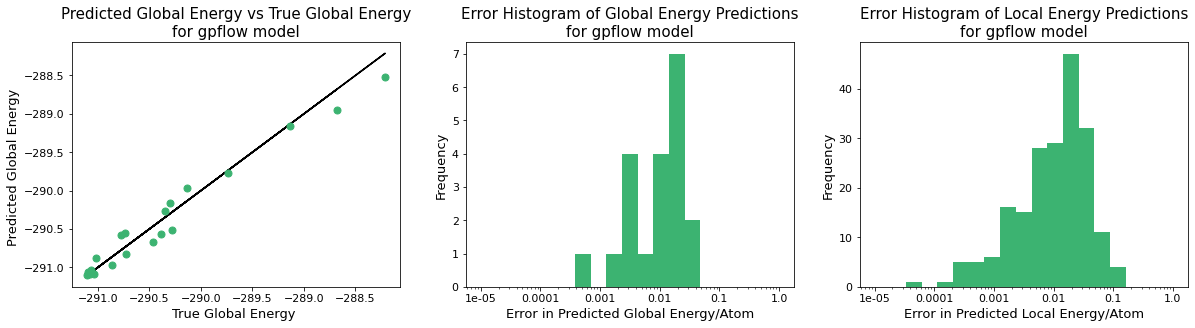

In [140]:

test_ens_regrouped = test_ens_rescaled.reshape(-1, len(StructureList[0]))
predict_ens_regrouped = predict_ens_rescaled.reshape(-1, len(StructureList[0]))
self_energies_regrouped = [[self_energy(atom.symbol) for atom in StructureList[i]] for i in test_indices]
test_global_ens = np.sum(test_ens_regrouped + self_energies_regrouped, axis=1)
predict_global_ens = np.sum(predict_ens_regrouped + self_energies_regrouped, axis=1)



plot_errors(model_description = "gpflow model",
            use_local=True,
            global_ens=test_global_ens,   predicted_global_ens= predict_global_ens,
            local_ens= test_ens_rescaled, predicted_local_ens = predict_ens_rescaled,
            color="mediumseagreen")
#plt.savefig("../media/librascal_database_local_energy_learning_gpflow_polynomial_kernel")

In [141]:
if use_forces:
    predict_frcs_rescaled


    fig, axs = plt.subplots(ncols=3, figsize=(20,5))
    components = ["x", "y", "z"]
    force_max = max(np.max(test_frcs_rescaled), np.max(predict_frcs_rescaled)) + np.std(test_frcs_rescaled)/2
    force_min = min(np.min(test_frcs_rescaled), np.min(predict_frcs_rescaled)) - np.std(test_frcs_rescaled)/2

    for i in range(3):

        axs[i].plot([force_min, force_max], [force_min, force_max], "-", c="k")
        axs[i].plot(test_frcs_rescaled[:,i], test_frcs_rescaled[:,i], "o", c="k", ms=4)
        axs[i].plot(test_frcs_rescaled[:,i], predict_frcs_rescaled[:,i], "o", label="custom", c="mediumseagreen", ms=5, alpha=.1)
        #axs[i].legend()
        axs[i].set_xlim(force_min, force_max); axs[i].set_ylim(force_min, force_max)

        try:
            m, b = np.polyfit(test_frcs_rescaled[:,i], predict_frcs_rescaled[:,i], 1)
            r2 = np.corrcoef(test_frcs_rescaled[:,i], predict_frcs_rescaled[:,i])[0,1]
            print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
        except:
            pass    

    #plt.savefig("../media/librascal_database_local_energy_force_learning")

# Linear Algebra Only Model

In [96]:

@tf.function(autograph=False, experimental_compile=False)
def get_KNN(soaps):
    dot_product_matrix = tf.tensordot(soaps, tf.transpose(soaps), axes=1)
    return dot_product_matrix


@tf.function(autograph=False, experimental_compile=False)
def get_coefficients(KNN, variance, y):
    KNNi = tf.linalg.inv(KNN + tf.eye(KNN.shape[0], dtype=np.float64) * variance )
    return tf.linalg.matmul(KNNi, y)


---
Local soap + energies tensorflow linear algebra method

In [107]:
GlobalEnergies_Train = np.float64(EnergyList[train_indices].sum(axis=1, dtype=np.float128))
GlobalEnergies_Test = np.float64(EnergyList[test_indices].sum(axis=1, dtype=np.float128))
LocalSoaps_Train = SoapList[train_indices]
LocalSoaps_Test = SoapList[test_indices]
ObservationNoiseVariance = noise_init#1e-5

In [108]:
TimePreTrainingLinAlg = time.time()

AtomCounts_Train = [len(soap_list_i) for soap_list_i in LocalSoaps_Train]#, dtype=np.float64)
LocalBools_Train = tf.repeat(tf.eye(len(AtomCounts_Train), dtype=np.float64), AtomCounts_Train, axis=1)
GlobalEnergies_Train_tf = tf.constant(GlobalEnergies_Train, dtype=np.float64)
AtomCounts_Train_tf = tf.constant(AtomCounts_Train, dtype=np.float64)
LocalEnergies_Train = tf.reshape(tf.repeat(tf.math.divide(GlobalEnergies_Train_tf, AtomCounts_Train_tf), AtomCounts_Train), [-1, 1])
#LocalEnergies_Train = tf.linalg.matmul(LocalBools_Train, GlobalEnergies_Train_tf, transpose_a=True)

LocalSoaps_Train_tf = tf.constant(LocalSoaps_Train, dtype=np.float64)
LocalSoaps_Train_tf = tf.reshape(LocalSoaps_Train_tf, [-1, LocalSoaps_Train_tf.shape[-1]])
KNN_Local = get_KNN(LocalSoaps_Train_tf)
print("calculated KNN")

ObservationNoiseVariance_tf = tf.constant(ObservationNoiseVariance, dtype=np.float64)
Coefficients_Local = get_coefficients(KNN_Local, ObservationNoiseVariance_tf, LocalEnergies_Train)
print("calculated coefficients")

TimePrePredictionLinAlg = time.time()

AtomCounts_Test = [len(soap_list_i) for soap_list_i in LocalSoaps_Test]
LocalBools_Test = tf.repeat(tf.eye(len(AtomCounts_Test), dtype=np.float64), AtomCounts_Test, axis=1)
GlobalEnergies_Test_tf = tf.constant(GlobalEnergies_Test, dtype=np.float64)
AtomCounts_Test_tf = tf.constant(AtomCounts_Test, dtype=np.float64)
LocalEnergies_Test = tf.reshape(tf.repeat(tf.math.divide(GlobalEnergies_Test_tf, AtomCounts_Test_tf), AtomCounts_Test), -1)
LocalEnergies_Test = tf.reshape(LocalEnergies_Test, -1)

LocalSoaps_Test_tf = tf.constant(LocalSoaps_Test, dtype=np.float64)
LocalSoaps_Test_tf = tf.reshape(LocalSoaps_Test_tf, [-1, LocalSoaps_Test_tf.shape[-1]])

PredictedLocalEnergies = predict_energies_from_weights(Coefficients_Local, LocalSoaps_Train_tf, LocalSoaps_Test_tf)
PredictedLocalEnergies = tf.reshape(PredictedLocalEnergies, [-1, 1])
print("Predicted local energies")
PredictedGlobalEnergies = tf.linalg.matmul(LocalBools_Test, PredictedLocalEnergies)
PredictedLocalEnergies = tf.reshape(PredictedLocalEnergies, -1)
PredictedGlobalEnergies = tf.reshape(PredictedGlobalEnergies, -1)
print("Predicted global energies")


TimePostPredictionLinAlg = time.time()

calculated KNN
calculated coefficients
Predicted local energies
Predicted global energies


In [109]:
TrainingTimeLinAlg = TimePrePredictionLinAlg - TimePreTrainingLinAlg
PredictionTime = TimePostPredictionLinAlg - TimePrePredictionLinAlg

print(TrainingTimeLinAlg, PredictionTime)

2.074242353439331 0.052350759506225586


,Local Energy,Global Energy
Root Mean Squared Error,0.028280,0.004826
Mean Absolute Error,0.019045,0.003141
Max Absolute Error,0.114966,0.014826


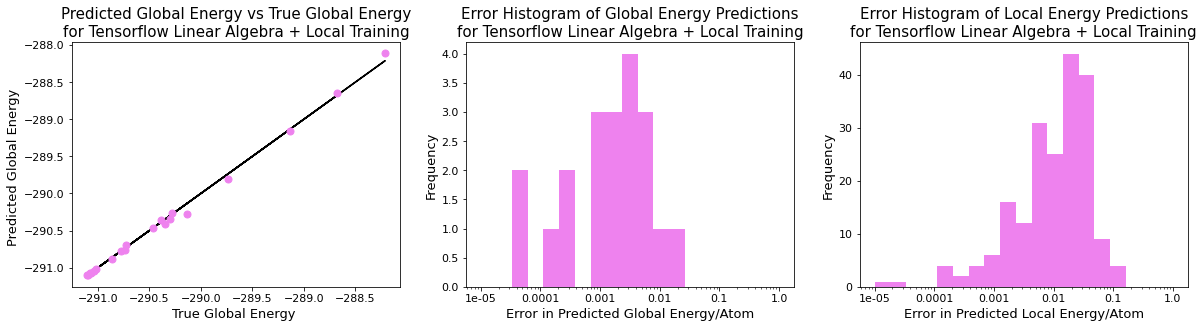

In [142]:

plot_errors(model_description = "Tensorflow Linear Algebra + Local Training",
            use_local=True,
            global_ens=GlobalEnergies_Test,   predicted_global_ens= PredictedGlobalEnergies,
            local_ens= LocalEnergies_Test,    predicted_local_ens = PredictedLocalEnergies,
            color="violet")

# ---

Local soap + energies tensorflow linear algebra method (sparse)

In [144]:
GlobalEnergies_Train = EnergyList[train_indices].sum(axis=1)
GlobalEnergies_Test = EnergyList[test_indices].sum(axis=1)
LocalSoaps_Train = SoapList[train_indices]
LocalSoaps_Test = SoapList[test_indices]
ObservationNoiseVariance = 1e-5

In [140]:
TimePreTrainingLinAlg = time.time()

AtomCounts_Train = [len(soap_list_i) for soap_list_i in LocalSoaps_Train]#, dtype=np.float64)
LocalBools_Train = tf.repeat(tf.eye(len(AtomCounts_Train), dtype=np.float64), AtomCounts_Train, axis=1)
GlobalEnergies_Train_tf = tf.constant(GlobalEnergies_Train, dtype=np.float64)
AtomCounts_Train_tf = tf.constant(AtomCounts_Train, dtype=np.float64)
LocalEnergies_Train = tf.reshape(tf.repeat(tf.math.divide(GlobalEnergies_Train_tf, AtomCounts_Train_tf), AtomCounts_Train), [-1, 1])
#LocalEnergies_Train = tf.linalg.matmul(LocalBools_Train, GlobalEnergies_Train_tf, transpose_a=True)

LocalSoaps_Train_tf = tf.constant(LocalSoaps_Train, dtype=np.float64)
LocalSoaps_Train_tf = tf.reshape(LocalSoaps_Train_tf, [-1, LocalSoaps_Train_tf.shape[-1]])
KNN_Local = get_KNN(LocalSoaps_Train_tf)
print("calculated KNN")

ObservationNoiseVariance_tf = tf.constant(ObservationNoiseVariance, dtype=np.float64)
Coefficients_Local = get_coefficients(KNN_Local, ObservationNoiseVariance_tf, LocalEnergies_Train)
print("calculated coefficients")

TimePrePredictionLinAlg = time.time()

AtomCounts_Test = [len(soap_list_i) for soap_list_i in LocalSoaps_Test]
LocalBools_Test = tf.repeat(tf.eye(len(AtomCounts_Test), dtype=np.float64), AtomCounts_Test, axis=1)
GlobalEnergies_Test_tf = tf.constant(GlobalEnergies_Test, dtype=np.float64)
AtomCounts_Test_tf = tf.constant(AtomCounts_Test, dtype=np.float64)
LocalEnergies_Test = tf.reshape(tf.repeat(tf.math.divide(GlobalEnergies_Test_tf, AtomCounts_Test_tf), AtomCounts_Test), -1)
LocalEnergies_Test = tf.reshape(LocalEnergies_Test, -1)

LocalSoaps_Test_tf = tf.constant(LocalSoaps_Test, dtype=np.float64)
LocalSoaps_Test_tf = tf.reshape(LocalSoaps_Test_tf, [-1, LocalSoaps_Test_tf.shape[-1]])

PredictedLocalEnergies = predict_energies_from_weights(Coefficients_Local, LocalSoaps_Train_tf, LocalSoaps_Test_tf)
PredictedLocalEnergies = tf.reshape(PredictedLocalEnergies, [-1, 1])
print("Predicted local energies")
PredictedGlobalEnergies = tf.linalg.matmul(LocalBools_Test, PredictedLocalEnergies)
PredictedLocalEnergies = tf.reshape(PredictedLocalEnergies, -1)
PredictedGlobalEnergies = tf.reshape(PredictedGlobalEnergies, -1)
print("Predicted global energies")


TimePostPredictionLinAlg = time.time()

calculated KNN
calculated coefficients
Predicted local energies
Predicted global energies


In [137]:
TrainingTimeLinAlg = TimePrePredictionLinAlg - TimePreTrainingLinAlg
PredictionTime = TimePostPredictionLinAlg - TimePrePredictionLinAlg

print(TrainingTimeLinAlg, PredictionTime)

0.01116633415222168 0.0019211769104003906


In [ ]:

plot_errors(model_description = "Tensorflow Linear Algebra + Sparse Local Training",
            use_local=True,
            global_ens=GlobalEnergies_Test,   predicted_global_ens= PredictedGlobalEnergies,
            local_ens= LocalEnergies_Test,    predicted_local_ens = PredictedLocalEnergies,
            color="violet")

---
Global soaps and energies only  
This may be useful for debugging/testing purposes, but it is not as relavent to miniGAP because GAP requires local properties

In [29]:
# librascal sums soaps of a given structure and element
# and dots them with sparse soaps of the same element
# To reproduce this in not sparse form, I will sum soaps of
# the whole structure and dot them with every other soap

In [127]:
# Because I split them into local energies and soaps
# But I am using the global versions for this linear algebra implementation
# I have to reform the global soaps and energies that I split above for my training

GlobalEnergies_Train = EnergyList[train_indices].sum(axis=1)
GlobalEnergies_Test = EnergyList[test_indices].sum(axis=1)
GlobalSoaps_Train = SoapList[train_indices].sum(axis=1)
GlobalSoaps_Test = SoapList[test_indices].sum(axis=1)
# Define this for regularization
ObservationNoiseVariance = 1e-5

In [128]:

TimePreTrainingLinAlg = time.time()
GlobalSoaps_Train_tf = tf.constant(GlobalSoaps_Train, dtype=np.float64)
KNN = get_KNN(GlobalSoaps_Train_tf)

ObservationNoiseVariance_tf = tf.constant(ObservationNoiseVariance, dtype=np.float64)
GlobalEnergies_Train_tf = tf.reshape(tf.constant(GlobalEnergies_Train, dtype=np.float64), [-1, 1])
Coefficients = get_coefficients(KNN, ObservationNoiseVariance_tf, GlobalEnergies_Train_tf)

TimePrePredictionLinAlg = time.time()

GlobalSoaps_Test_tf = tf.constant(GlobalSoaps_Test, dtype=np.float64)
PredictedGlobalEnergies = predict_energies_from_weights(Coefficients, GlobalSoaps_Train_tf, GlobalSoaps_Test_tf)
PredictedGlobalEnergies = tf.reshape(PredictedGlobalEnergies, -1)

TimePostPredictionLinAlg = time.time()


In [129]:
TrainingTimeLinAlg = TimePrePredictionLinAlg - TimePreTrainingLinAlg
PredictionTime = TimePostPredictionLinAlg - TimePrePredictionLinAlg

print(TrainingTimeLinAlg, PredictionTime)

0.01116633415222168 0.0019211769104003906


,Local Energy,Global Energy
Root Mean Squared Error,0.004826,0.004826
Mean Absolute Error,0.003141,0.003141
Max Absolute Error,0.014826,0.014826


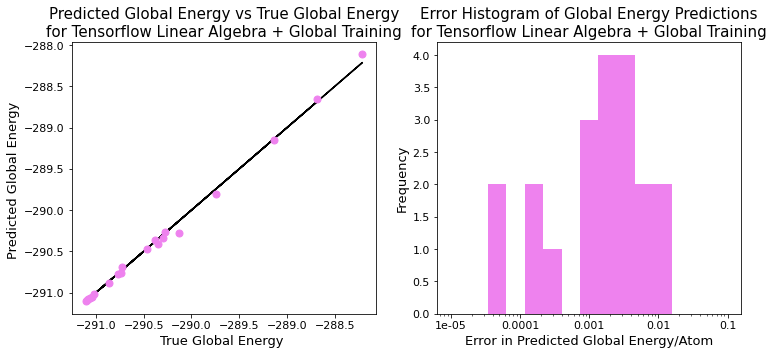

In [143]:
plot_errors(model_description = "Tensorflow Linear Algebra + Global Training",
            use_local=False,
            global_ens=GlobalEnergies_Test,   predicted_global_ens= PredictedGlobalEnergies,
            color="violet")

# Save as script 

The following cell will save this notebook as a python script with today's date in the code directory 

In [127]:
import datetime as dt 
today = dt.datetime.today()
converted_notebook_path = "../code/miniGAP_from_notebook_{:02d}_{:02d}_{:d}".format(today.month, today.day, today.year)
!jupyter nbconvert --to script miniGAP.ipynb --output "{converted_notebook_path}"

[NbConvertApp] Converting notebook miniGAP.ipynb to script
[NbConvertApp] Writing 26218 bytes to ../code/miniGAP_from_notebook_09_27_2021.py
